In [2]:
!pwd

/teamspace/studios/this_studio/Latent-Diffusion-Model-for-text-to-image-generation


In [11]:
!pip install --upgrade torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.8/899.8 MB 42.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 59.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 173.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 197.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 50.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 166.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 201.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 121.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 110.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!pip install diffusers transformers tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 181.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 205.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 791.5/791.5 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 140.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 154.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [1]:
import torch
from torch.utils.data import DataLoader,Dataset
from torchvision.transforms import transforms
from diffusers import UNet2DConditionModel, DDPMScheduler, AutoencoderKL
from transformers import CLIPTokenizer, CLIPTextModel
from tqdm.auto import tqdm
from PIL import Image
import os
import json

print(torch.__version__)

2.9.0+cu128


In [2]:

# Parameters
batch_size = 8  # Reduced batch size for stability
epochs = 2
learning_rate = 1e-4
image_size = 128  # Increased image size
latent_size = image_size // 16  # Calculate latent size (512 -> 64)
data_path = "/teamspace/studios/this_studio/coco"
device = "cuda" if torch.cuda.is_available() else "cpu"


In [3]:

# Tokenizer and Transforms
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
max_length = 77


In [4]:

class CocoWithAnnotations(Dataset):
    def __init__(self, path, tokenizer, transform, train=True):
        super().__init__()
        self.path = path
        self.data = None
        self.transform = transform
        self.tokenizer = tokenizer
        self.train = train
        if self.data is None:
            self.open_json()

    def open_json(self):
        split = "train" if self.train else "val"
        print(f'Loading {split} annotations...')
        with open(f'{self.path}/annotations/captions_{split}2014.json', 'r') as stream:
            self.data = json.load(stream)['annotations']
        print('Annotations loaded')

    def __getitem__(self, index):
        annot = self.data[index]
        img_id = str(annot['image_id']).zfill(12)
        split = "train" if self.train else "val"
        
        try:
            image_path = f'{self.path}/{split}2014/COCO_{split}2014_{img_id}.jpg'
            image = Image.open(image_path).convert('RGB')
            image = self.transform(image)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Return a default item in case of error
            return torch.zeros((3, image_size, image_size)), torch.zeros((max_length,))

        text_emb = self.tokenizer(
            annot['caption'],
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )
        return image, text_emb.input_ids.squeeze(0)

    def __len__(self):
        return len(self.data)

In [5]:
# Models with proper configuration
unet = UNet2DConditionModel(
    sample_size=latent_size,  # Use calculated latent size
    in_channels=4,
    out_channels=4,
    layers_per_block=2,
    block_out_channels=(128, 256, 512, 512),
    down_block_types=(
        "CrossAttnDownBlock2D",
        "CrossAttnDownBlock2D",
        "CrossAttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "CrossAttnUpBlock2D",
        "CrossAttnUpBlock2D",
        "CrossAttnUpBlock2D",
    ),
    cross_attention_dim=512,  # Match CLIP's hidden dimension
).to(device)

# Load pretrained models
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
autoencoder = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse").to(device)
diffusion = DDPMScheduler(num_train_timesteps=1000, beta_schedule="linear")

# Freeze VAE and text encoder
for param in autoencoder.parameters():
    param.requires_grad = False
for param in text_encoder.parameters():
    param.requires_grad = False

# Dataset and DataLoader with error handling
def collate_fn(batch):
    # Filter out any None values from failed loads
    batch = [(img, cap) for img, cap in batch if img is not None and cap is not None]
    if not batch:
        return None
    images, captions = zip(*batch)
    return torch.stack(images), torch.stack(captions)

dataset = CocoWithAnnotations(data_path, tokenizer, transform, train=True)
dataloader = DataLoader(
    dataset, 
    batch_size=batch_size, 
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=4,
)



Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading train annotations...
Annotations loaded


In [6]:
dataset[0][0]

tensor([[[-0.6078, -0.6157, -0.6157,  ..., -0.6627, -0.7569, -0.6863],
         [-0.6000, -0.6157, -0.6078,  ..., -0.3647, -0.5922, -0.6784],
         [-0.5843, -0.6078, -0.6157,  ..., -0.4745, -0.5608, -0.6706],
         ...,
         [-0.0039, -0.0039,  0.0196,  ..., -0.1451, -0.1608, -0.1765],
         [-0.0431, -0.0431, -0.0275,  ..., -0.1686, -0.1843, -0.1922],
         [-0.0431, -0.0431, -0.0353,  ..., -0.1922, -0.2078, -0.2235]],

        [[-0.3569, -0.3569, -0.3490,  ..., -0.6157, -0.6863, -0.5843],
         [-0.3333, -0.3255, -0.3176,  ..., -0.3647, -0.5686, -0.5608],
         [-0.3176, -0.2941, -0.2863,  ..., -0.4510, -0.5451, -0.5765],
         ...,
         [-0.0275, -0.0353, -0.0275,  ..., -0.1843, -0.2000, -0.2000],
         [-0.0667, -0.0667, -0.0588,  ..., -0.2157, -0.2235, -0.2314],
         [-0.0667, -0.0667, -0.0588,  ..., -0.2314, -0.2471, -0.2471]],

        [[-0.1529, -0.1373, -0.1294,  ..., -0.5765, -0.5922, -0.5373],
         [-0.0980, -0.1137, -0.1059,  ..., -0

In [7]:
dataset[0][0]

tensor([[[-0.6078, -0.6157, -0.6157,  ..., -0.6627, -0.7569, -0.6863],
         [-0.6000, -0.6157, -0.6078,  ..., -0.3647, -0.5922, -0.6784],
         [-0.5843, -0.6078, -0.6157,  ..., -0.4745, -0.5608, -0.6706],
         ...,
         [-0.0039, -0.0039,  0.0196,  ..., -0.1451, -0.1608, -0.1765],
         [-0.0431, -0.0431, -0.0275,  ..., -0.1686, -0.1843, -0.1922],
         [-0.0431, -0.0431, -0.0353,  ..., -0.1922, -0.2078, -0.2235]],

        [[-0.3569, -0.3569, -0.3490,  ..., -0.6157, -0.6863, -0.5843],
         [-0.3333, -0.3255, -0.3176,  ..., -0.3647, -0.5686, -0.5608],
         [-0.3176, -0.2941, -0.2863,  ..., -0.4510, -0.5451, -0.5765],
         ...,
         [-0.0275, -0.0353, -0.0275,  ..., -0.1843, -0.2000, -0.2000],
         [-0.0667, -0.0667, -0.0588,  ..., -0.2157, -0.2235, -0.2314],
         [-0.0667, -0.0667, -0.0588,  ..., -0.2314, -0.2471, -0.2471]],

        [[-0.1529, -0.1373, -0.1294,  ..., -0.5765, -0.5922, -0.5373],
         [-0.0980, -0.1137, -0.1059,  ..., -0

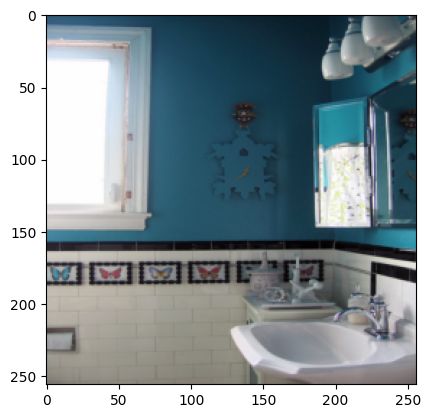

In [8]:
import matplotlib.pyplot as plt
plt.imshow(dataset[0][0].detach().permute(1, 2, 0).cpu().numpy()/2+0.5)

In [9]:
dataset[0][1]

tensor([49406,   320,  1070,  3772,   537,  1123, 15917,  7893,  8470, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407])

In [10]:
decoded_text = tokenizer.decode(dataset[0][1], skip_special_tokens=True)
print("Decoded Text:", decoded_text)

Decoded Text: a very clean and well decorated empty bathroom


In [11]:
# Optimizer with gradient clipping
optimizer = torch.optim.AdamW(unet.parameters(), lr=learning_rate)
scaler = torch.cuda.amp.GradScaler()  # For mixed precision training

# Training loop with improved error handling and mixed precision
for epoch in range(epochs):
    unet.train()
    epoch_loss = 0
    valid_batches = 0
    
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}")
    for batch in progress_bar:
        if batch is None:
            continue
            
        images, captions = batch
        images = images.to(device)
        captions = captions.to(device)

        with torch.cuda.amp.autocast():
            # Encode images
            with torch.no_grad():
                latents = autoencoder.encode(images).latent_dist.sample()
                latents = latents * 0.18215

            # Noise augmentation
            noise = torch.randn_like(latents)
            timesteps = torch.randint(0, diffusion.config.num_train_timesteps, (latents.shape[0],), device=device)
            noisy_latents = diffusion.add_noise(latents, noise, timesteps)

            # Get text embeddings
            with torch.no_grad():
                encoder_hidden_states = text_encoder(captions)[0]

            # Predict noise
            noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample
            loss = torch.nn.functional.mse_loss(noise_pred, noise, reduction="mean")

        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(unet.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        epoch_loss += loss.item()
        valid_batches += 1
        progress_bar.set_postfix({"loss": loss.item()})

    avg_loss = epoch_loss / valid_batches
    print(f"Epoch {epoch + 1} completed with average loss: {avg_loss:.4f}")

    # Save checkpoint after each epoch
    checkpoint_dir = f"./ldm_checkpoints/epoch_{epoch + 1}"
    os.makedirs(checkpoint_dir, exist_ok=True)
    unet.save_pretrained(os.path.join(checkpoint_dir, "unet"))
    torch.save({
        'epoch': epoch,
        'model_state_dict': unet.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_loss,
    }, os.path.join(checkpoint_dir, "training_state.pth"))

print("Training completed!")

/tmp/ipykernel_116341/1185090775.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # For mixed precision training


Epoch 1/2:   0%|          | 0/51765 [00:00<?, ?it/s]

/tmp/ipykernel_116341/1185090775.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


KeyboardInterrupt: 